# About the code

This code is going to be the main to collect and create analysis output to answer the question "Quantifying political stance of Japanese Diet members regards specific political topics through the use of LLMs and statistical methods." (Tentative) 
## Procedure
1. Create embeddings for each opinion-based sentence in regards to different topics and store it in a retrievable manner.
2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.
3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data
4. Collapse all the other vectors onto this axis by projecting them onto the axis
5. Create a scalar measurement for how far each politician is from the two reference points

## Notes
- Data is stored under `data/data_repr` directory
- We will attempt the procedure with different models to seek the best output


In [49]:
import os
from sentence_transformers import models, SentenceTransformer
import h5py
import numpy as np
import torch
from params.paths import ROOT_DIR
from logger.Logger import Logger
from file_handling.file_read_writer import read_json, write_json, create_dir, write_file, read_hdf5_file

VERBOSE = True
logger = Logger(verbose=VERBOSE)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_REPR_SPEECHES_DIR = os.path.join(DATA_DIR, 'data_repr')
PARTIES = [party for party in os.listdir(DATA_REPR_SPEECHES_DIR) if not '.' in party]
PARTY_TO_COLOR = {
	'自民': 'black',
	'国民': 'blue',
	'立憲': 'orange',
	'公明': 'lightblue',
	'共産': 'red',
	'維新': 'yellow',
	'れ新': 'green',
	'無': 'purple',
	'有志': 'grey'
}
if len(PARTIES) != len(PARTY_TO_COLOR):
	raise ValueError('PARTIES and PARTY_TO_COLOR must have the same length.')
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"
print('-----------------------------------')
print('DATA_DIR: ', DATA_DIR)
print('DATA_REPR_SPEECHES_DIR: ', DATA_REPR_SPEECHES_DIR)
print('PARTIES: ', PARTIES)
print('-----------------------------------')

-----------------------------------
DATA_DIR:  /root/projects/kokkai_analysis/data_prepping/params/../data
DATA_REPR_SPEECHES_DIR:  /root/projects/kokkai_analysis/data_prepping/params/../data/data_repr
PARTIES:  ['自民', '国民', '公明', '立憲', 'れ新', '維新', '無', '共産', '有志']
-----------------------------------


In [50]:
# adapted from: https://osima.jp/posts/sentence-bert/

sentence_transformer = models.Transformer(MODEL_NAME)

pooling = models.Pooling(
    sentence_transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=False,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False)

st = SentenceTransformer(modules=[sentence_transformer, pooling])

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 1. Creating the embeddings for each opinon based sentence

In [ ]:
def embed_speeches(speeches):
	encoded_opinions = st.encode(speeches, convert_to_tensor=True, show_progress_bar=True)
	return encoded_opinions

def read_opinion_sentences_and_dates(file_path):
	logger.message(f'Reading {file_path}')
	target_dict = read_json(file_path)
	opinion_sentences = []
	dates = []
	for speech in target_dict['speeches']:
		date = [speech['date'] for _ in range(len(speech['extracted_opinions']))]
		opinions = speech['extracted_opinions']
		opinion_sentences.extend(opinions)
		dates.extend(date)
	
	return opinion_sentences, dates

def iterate_topics_for_repr(repr_path, topics=[]):
	for topic in os.listdir(repr_path):
		if topic not in topics and topics:
			continue
		logger.message(f'Working on {topic}')
		topic_path = os.path.join(repr_path, topic)
		if os.path.exists(os.path.join(topic_path, 'embeddings.hdf5')):
			logger.message(f'Embeddings already exist for {topic} in {repr_path}')
			continue
		file_paths = [os.path.join(topic_path, file) for file in os.listdir(topic_path) if file.endswith('.json')]
		topic_opinions = []
		topic_dates = []
		for file_path in file_paths:
			opinion_sentences, dates = read_opinion_sentences_and_dates(file_path)
			topic_opinions.extend(opinion_sentences)
			topic_dates.extend(dates)
		embeddings = embed_speeches(topic_opinions)
		embeddings = [embedding.cpu() for embedding in embeddings]
		logger.message(f'Number of dates {len(topic_dates)}\nNumber of opinions {len(topic_opinions)} \nNumber of embeddings {len(embeddings)}')
		embeddings = torch.stack(embeddings)
		with h5py.File(os.path.join(topic_path, 'embeddings.hdf5'), 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('dates', data=topic_dates, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('opinions', data=topic_opinions, dtype=h5py.string_dtype(encoding='utf-8'))

for party in PARTIES:
	party_path = os.path.join(DATA_REPR_SPEECHES_DIR, party)
	repr_names = os.listdir(party_path)
	for repr_name in repr_names:
		logger.message(f'{party} ----- {repr_name}')
		repr_path = os.path.join(party_path, repr_name)
		iterate_topics_for_repr(repr_path, topics=['防衛'])

## 2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.

In [ ]:
class EmbeddingHandler:
	def __init__(self, data_dir=DATA_DIR, speeches_dir = DATA_REPR_SPEECHES_DIR, parties=PARTIES):
		self.data_dir = data_dir
		self.speeches_dir = speeches_dir
		self.parties = parties
		self.reprs = []
		self.repr2party = {}
		for party in self.parties:
			reprs = os.listdir(os.path.join(self.speeches_dir, party))
			self.reprs.extend(reprs)
			for repr in reprs:
				self.repr2party[repr] = party

	def check_party_exists(self, party):
		if party not in self.parties:
			raise ValueError(f'{party} not in {self.parties}')
		
	def get_reprs_for_party(self, party):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party))

	def get_topics_for_repr(self, party, repr_name):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party, repr_name))

	def get_embeddings_for_repr_for_topic(self,repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		path = os.path.join(self.speeches_dir, party, repr_name, topic, 'embeddings.hdf5')
		if not os.path.exists(path):
			raise ValueError(f'{path} does not exist')
		
		with h5py.File(path, 'r') as f:
			embeddings = f['embeddings'][:]
			dates = [date.decode('utf-8') for date in f['dates'][:]]
			opinions = [opinion.decode('utf-8') for opinion in f['opinions'][:]]
			return embeddings, dates, opinions
		
	def get_average_embedding_for_repr_for_topic(self, repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		embeddings, _, _= self.get_embeddings_for_repr_for_topic(repr_name, topic, party=party)
		return np.mean(embeddings, axis=0)
	
	def create_summary_hdf5_file_for_average_embeddings(self, path, topic, reprs=None):
		if reprs is None:
			reprs = self.reprs
		embeddings = []
		reprs_with_embeddings = []
		for repr in reprs:
			try:
				average_embedding = self.get_average_embedding_for_repr_for_topic(repr, topic)
				embeddings.append(average_embedding)
				reprs_with_embeddings.append(repr)
			except ValueError:
				logger.message(f'No embeddings for {repr} for {topic}')
				continue

		embeddings = np.array(embeddings)
		with h5py.File(path, 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('reprs', data=reprs_with_embeddings, dtype=h5py.string_dtype(encoding='utf-8'))

In [18]:
#example usage
eh = EmbeddingHandler()
print('all reprs')
print(eh.reprs)
print('repr2party')
print(eh.repr2party)
print('reprs for 自民')
print(eh.get_reprs_for_party('自民'))
print('topics for 自民 and 新藤義孝')
print(eh.get_topics_for_repr('自民', '新藤義孝'))
embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic('新藤義孝', '少子化')
print('embeddings shape', embeddings.shape)
print(f"{len(dates)} dates ---- sample: {dates[0]}")
print(f"{len(opinions)} opinions ---- sample: {opinions[0]}")
mean_embedding = eh.get_average_embedding_for_repr_for_topic('新藤義孝', '少子化')
print('mean embedding shape', mean_embedding.shape)

#nh creating a summary hdf5 file for all embeddings for one topic

print('Creating summary hdf5 file for all embeddings for one topic 防衛予算')
eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, '防衛予算.hdf5'),
												   topic = '防衛予算')
##checking the file just created
hdf5_dict = read_hdf5_file(os.path.join(DATA_REPR_SPEECHES_DIR, '防衛予算.hdf5'))
print('keys', hdf5_dict.keys())
print('embeddings shape', hdf5_dict['embeddings'].shape)
print('reprs', [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]])
print('reprs shape', hdf5_dict['reprs'].shape)
eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, '防衛.hdf5'),
												   topic = '防衛')



all reprs
['関芳弘', '新藤義孝', '鷲尾英一郎', '江藤拓', '義家弘介', '高村正大', '高鳥修一', '中谷真一', '森英介', '藤丸敏', '柴山昌彦', '中谷元', '下村博文', '岸田文雄', '小渕優子', '勝俣孝明', '小泉進次郎', '吉野正芳', '中曽根康隆', '宮下一郎', '平井卓也', '菅義偉', '石井拓', '西村明宏', '木村次郎', '上杉謙太郎', '八木哲也', '小林茂樹', '松島みどり', '菅家一郎', '鈴木憲和', '渡辺孝一', '林幹雄', '石破茂', '堀井学', '石原正敬', '上田英俊', '井上信治', '城内実', '古賀篤', '東国幹', '橘慶一郎', '林芳正', '遠藤利明', '村上誠一郎', '小森卓郎', '高見康裕', '後藤茂之', '神田潤一', '牧島かれん', '小林史明', '国光あやの', '田所嘉徳', '茂木敏充', '高木宏壽', '山本左近', '泉田裕彦', '宮崎政久', '山下貴司', '野中厚', '加藤勝信', '稲田朋美', '伊藤達也', '齋藤健', '船田元', '土屋品子', '上川陽子', '五十嵐清', '和田義明', '棚橋泰文', '甘利明', '門山宏哲', '工藤彰三', '大塚拓', '加藤鮎子', '山田賢司', '松本洋平', '伊藤信太郎', '石田真敏', '江崎鐵磨', '福田達夫', '務台俊介', '斎藤洋明', '越智隆雄', '岩屋毅', '山本ともひろ', '木原誠二', '古川直季', '鬼木誠', '永岡桂子', '江渡聡徳', '国定勇人', '根本幸典', '辻清人', '小倉將信', '今枝宗一郎', '井野俊郎', '黄川田仁志', 'あかま二郎', '田野瀬太道', '柿沢未途', '保岡宏武', '宮澤博行', '山際大志郎', '杉田水脈', '梶山弘志', '小野寺五典', '鈴木英敬', '鈴木隼人', '松野博一', '鈴木俊一', '大西英男', '宮路拓馬', '古川康', '武部新', '山口俊一', '奥野信亮', '田中良生', 'あべ俊子', '田中英之', '野田聖子', '神田憲次', '田畑裕明', '熊田裕通', '上野賢

## 3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data

In [55]:
import numpy as np
import matplotlib.pyplot as plt


class VectorOperator:
	def __init__(self):
		self.embedding_handler = EmbeddingHandler()
	
	def project_vector(vector, onto_vector):
		normalized_onto_vector = onto_vector / np.linalg.norm(onto_vector)
		scaling = np.dot(vector, normalized_onto_vector)
		projection = scaling * normalized_onto_vector
		return projection, scaling
	
	def get_embeddings_and_reprs(self, summary_hdf5_path):
		hdf5_dict = read_hdf5_file(summary_hdf5_path)
		embeddings = hdf5_dict['embeddings'][:]
		reprs = [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]]
		return embeddings, reprs
	
	def collapse_vectors_onto_two_ref_reprs(self, summary_hdf5_path, topic, ref_repr1, ref_repr2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		if ref_repr1 not in reprs:
			raise ValueError(f'{ref_repr1} not in {reprs}')
		if ref_repr2 not in reprs:
			raise ValueError(f'{ref_repr2} not in {reprs}')
		ref1_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr1, topic)
		ref2_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr2, topic)
		ref1_to_ref2 = ref2_embedding - ref1_embedding
		projections = embeddings @ ref1_to_ref2
		return projections, reprs
	
class PoliticalStanceVisualizer:
	def __init__(self):
		pass
	def on_single_axis(self, xs, labels, colors, title, xlabel):
		fig, ax = plt.subplots()
		ax.scatter(xs, np.zeros(len(xs)), c =colors, alpha=0.3)
		# ax.set_title(title, fontname='Yu Mincho')
		# ax.set_xlabel(xlabel, fontname='Yu Mincho')
		# for i, label in enumerate(labels):
		# 	ax.annotate(label, (xs[i], 0))
		plt.show()

		

	

parties ['自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '自民', '

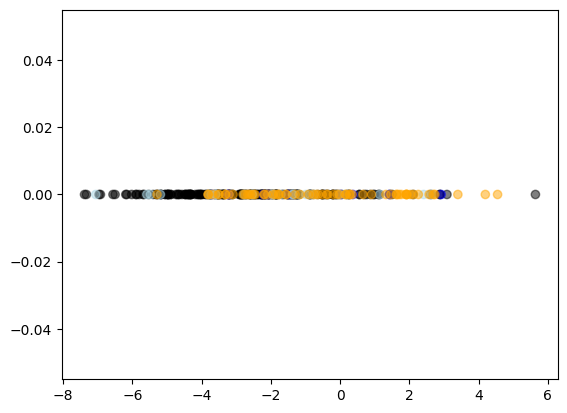

In [56]:
# testing above code


vo = VectorOperator()
psv = PoliticalStanceVisualizer()
projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, '防衛.hdf5'),
															topic='防衛',
															ref_repr1='石破茂',
															ref_repr2='枝野幸男')
parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
print('parties', parties)
print('projections shape', projections.shape)
print('Number of reprs', len(reprs))
print('projections', projections)

psv.on_single_axis(xs=projections,
				   labels=reprs,
				   colors=[PARTY_TO_COLOR[party] for party in parties],
				   title='防衛予算',
				   xlabel='石破茂 -> 枝野幸男')


## 4. Collapse all the other vectors onto this axis by projecting them onto the axis

## 5. Create a scalar measurement for how far each politician is from the two reference points